In [4]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import sys,pickle,glob
from tqdm import tqdm_notebook as tq
from IPython.display import display
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from collections import Counter
from IPython.core.display import display
#from pathos import multiprocessing as mp

from matplotlib import pyplot as plt
import seaborn
colors = seaborn.color_palette()
xr_full = range(1991,2016)
xr = range(1992,2016)
%matplotlib inline

In [5]:
DATADIR = '../results/'
#DATADIR = '/Users/jaredlorince/Desktop/'
# files = glob.glob(DATADIR+'by-cat-results/results*')
# cats = set([f[f.rfind('_')+1:] for f in files])
# print(sorted(cats))

In [6]:
cat_pubs_by_year = pd.read_pickle(DATADIR+'cat_pubs_by_year.pkl')
cat_citations_by_year = pd.read_pickle(DATADIR+'cat_citations_by_year.pkl')
cat_authors_by_year = pd.read_pickle(DATADIR+'cat_authors_by_year.pkl')

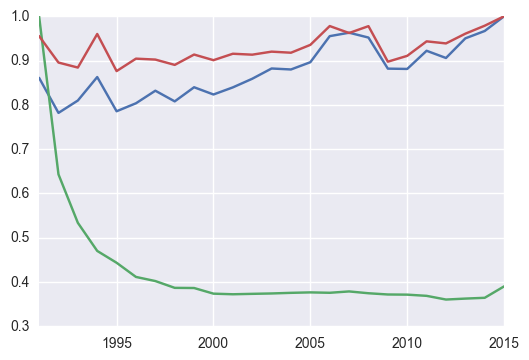

In [7]:
cat =  'Physics, Applied'
p = (cat_pubs_by_year[cat] / cat_pubs_by_year['ALL'])
(p/p.max()).plot()
c = (cat_citations_by_year[cat] / cat_citations_by_year['ALL'])
(c/c.max()).plot()
a = (cat_authors_by_year[cat] / cat_authors_by_year['ALL'])
(a/a.max()).plot()


In [8]:
props = cat_pubs_by_year.divide(cat_pubs_by_year['ALL'],axis=0)
growth = np.log10(props/props.shift(1))

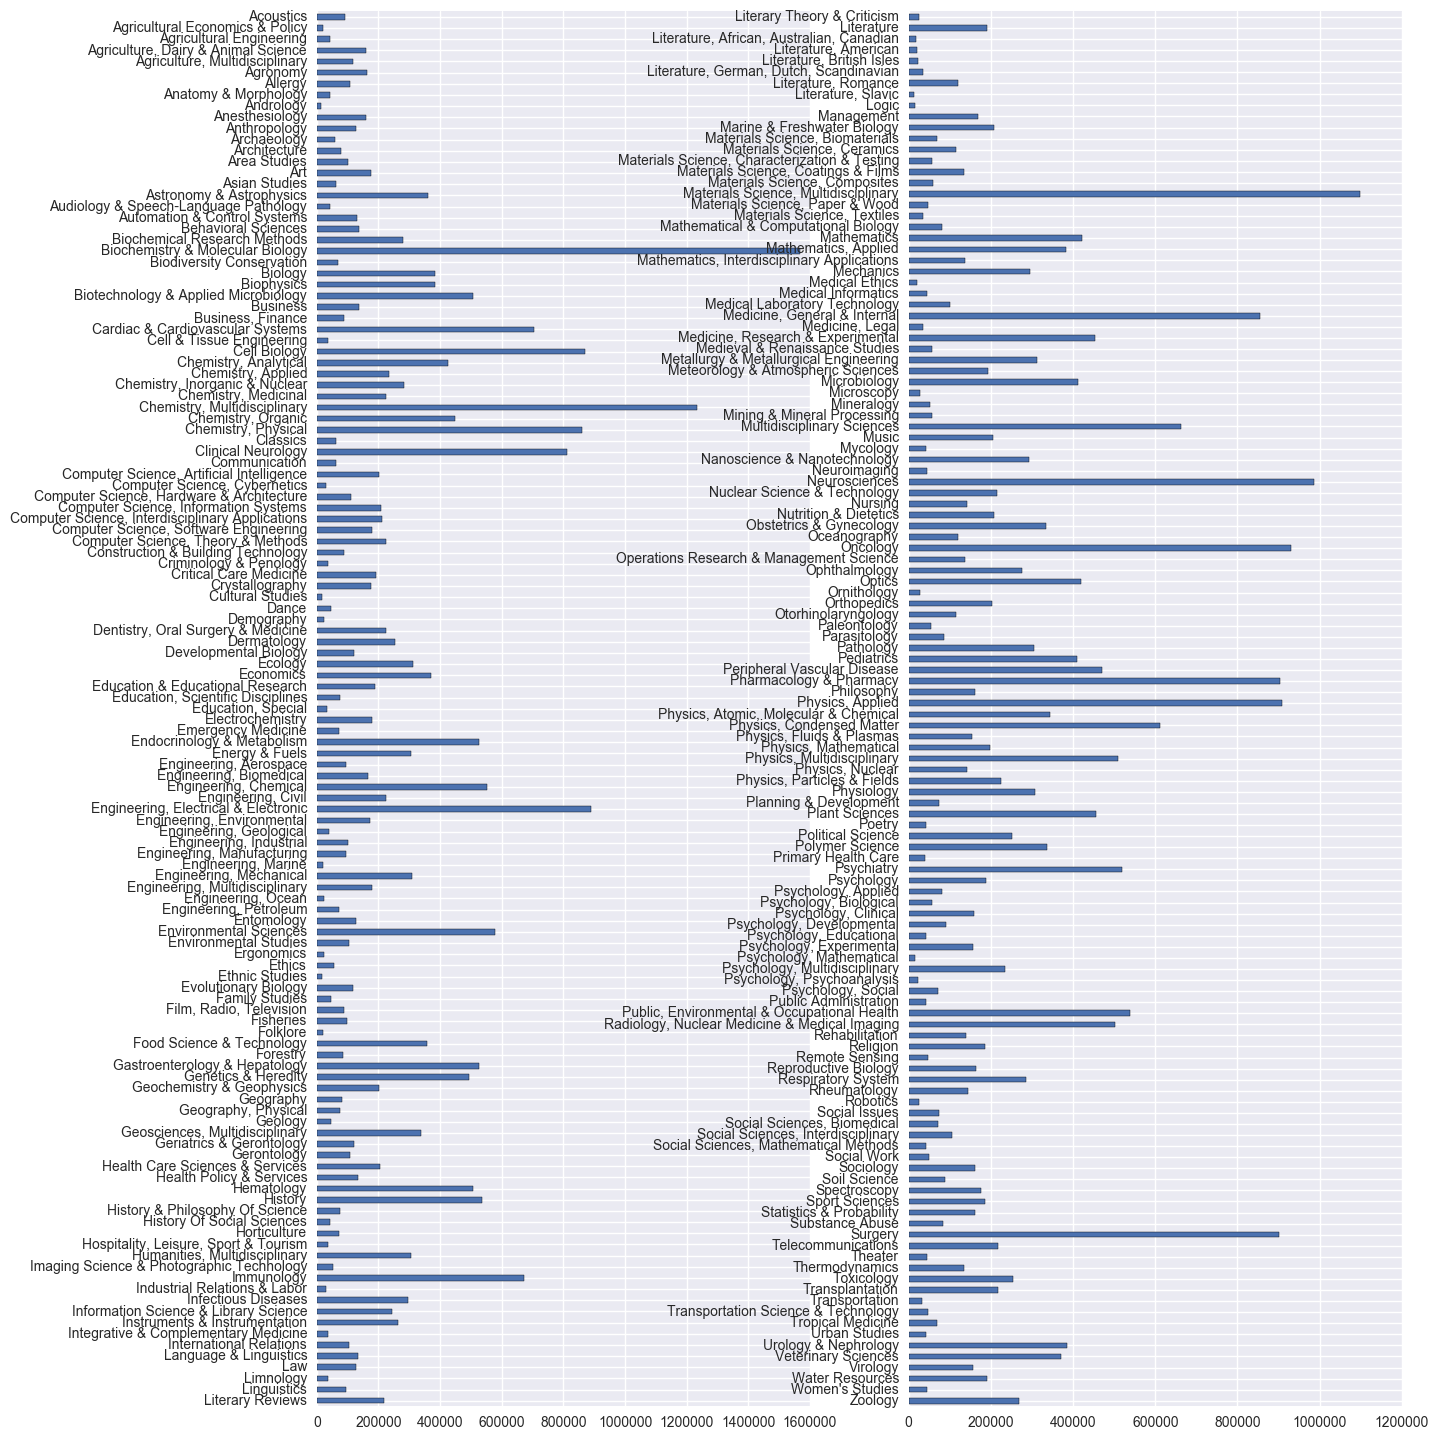

In [9]:
#just a big bar plot of the overall number of pubs for each field
fig,axes = plt.subplots(1,2,figsize=(14,18))
mx = cat_pubs_by_year.sum(0)[:-1].max()
cat_pubs_by_year.sum(0)[:125][::-1].plot(kind='barh',ax=axes[0],ylim=(0,mx))
cat_pubs_by_year.sum(0)[125:-1][::-1].plot(kind='barh',ax=axes[1],ylim=(0,mx));

In [10]:
def growth(cat,window):
    mx = len(cat_pubs_by_year)-(2*window-1)
    result = []
    for i in range(mx):
        a = cat_pubs_by_year[cat][i:i+window].sum()
        aprop = a/cat_pubs_by_year['ALL'][i:i+window].sum()
        b = cat_pubs_by_year[cat][i+window:i+window*2].sum()
        bprop = b/cat_pubs_by_year['ALL'][i+window:i+window*2].sum()
        result.append(np.log(bprop/aprop))    
    return np.array(result)

In [11]:
def parse_results(fi):
    df =  pd.read_table(fi,header=None,names=['measure','data'],index_col='measure')
    df.data = df.data.apply(lambda x: np.array(x.split(','),dtype=float))
    return df

In [12]:
colors = seaborn.color_palette()
def plotter(cat,window_size,mode='local'):
    #df = parse_results("{}by-cat-results/results_{}_{}".format(DATADIR,window_size,cat))
    df = parse_results("{}by-cat-results/{}_null/results_{}_{}".format(DATADIR,mode,window_size,cat))
    start = 1991+window_size-.5
    r = np.arange(start,start+len(df.ix['jsds'][0]))
    if window_size%2==0:
        r2 = np.arange(1991,1991+len(df.ix['ents'][0]))
    else:
        r2 = np.arange(start,start+len(df.ix['ents'][0]))

    fig,axes = plt.subplots(1,4,figsize=(16,4))
    
    ax = axes[0]
    ax.plot(r,df.ix['jsds'][0],label='JSD (raw)',color=colors[0])
    ax.plot(r,df.ix['ent_difs'][0],label=r'$\Delta H$ (raw)',color=colors[1])
    ax.plot(r,df.ix['jsd-null_m'][0],label='JSD (null)',c=colors[0],ls='--')
    ax.plot(r,df.ix['entdif-null_m'][0],label=r'$\Delta H$ (null)',color=colors[1],ls='--')
    #ax.fill_between(r,df.ix['entropy-null_m'][0]+df.ix['entropy-null_c'][0],df.ix['entropy-null_m'][0]-df.ix['entropy-null_c'][0],color=colors[1],alpha=.25)
    ax.axhline(0,c='k',ls='--')
    ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))
    ax.legend(loc='lower right',fontsize='medium')
    ax.set_title('Change measures')

    ax = axes[1]
    ax.plot(r2,df.ix['ents'][0],label='H (raw)')
    if mode == 'global':
        ax.plot(r2,df.ix['entropy-null_m'][0],label='H (null)',color=colors[1])
        ax.fill_between(r2,df.ix['entropy-null_m'][0]+df.ix['entropy-null_c'][0],df.ix['entropy-null_m'][0]-df.ix['entropy-null_c'][0],color=colors[1],alpha=.25)
    ax.set_title('Entropy')
    ax.legend(loc='lower right')
    
    ax = axes[2]
    ax.plot(r,growth(cat,window_size),label='Growth')
    ax.axhline(0,c='k',ls='--')
    ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))
    ax.set_title('Growth')
    
    ax = axes[3]
    ax.plot(r,df.ix['jsds'][0]-df.ix['jsd-null_m'][0],label='JSD (corrected)',color=colors[0])
    ax.plot(r,df.ix['ent_difs'][0]-df.ix['entdif-null_m'][0],label=r'$\Delta H$ (corrected)',color=colors[1])
    ax.legend(loc='upper right')
    ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))    
    ax.set_title('Corrected measures')
    
    fig.suptitle(cat)
    

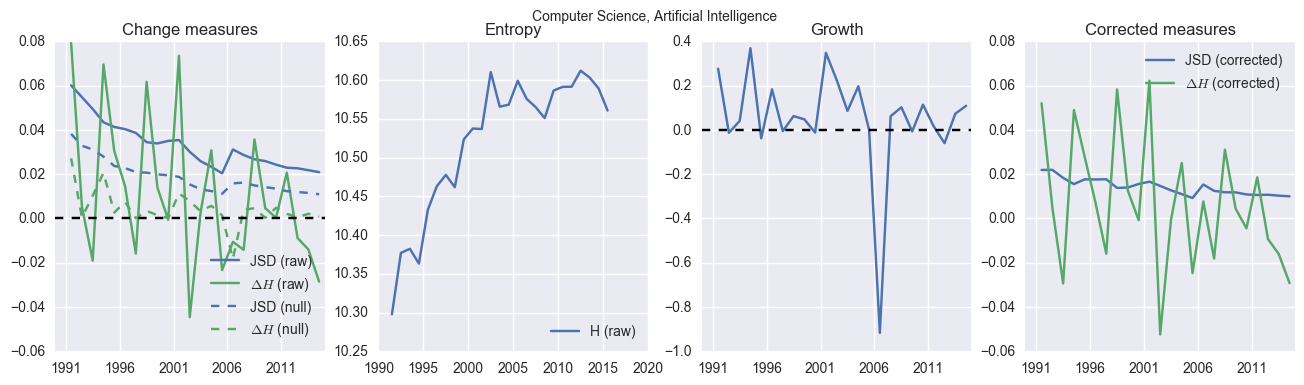

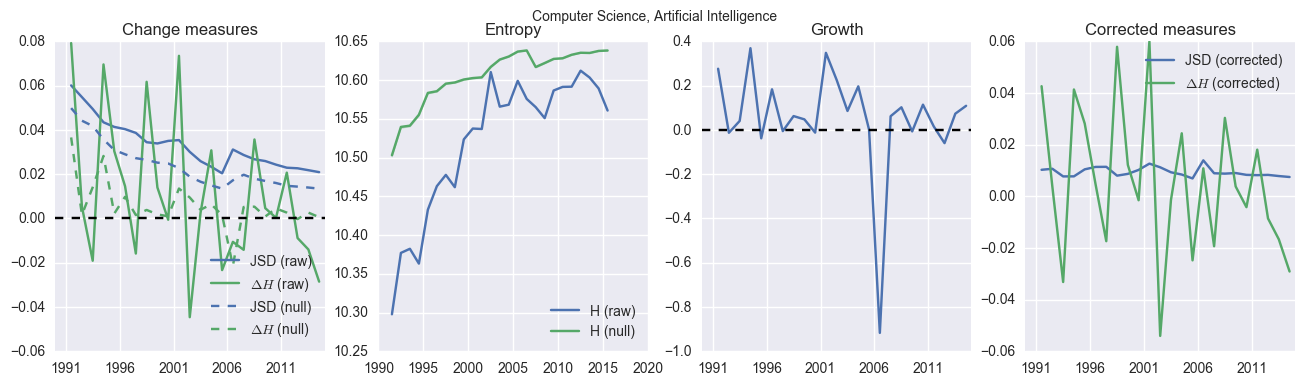

In [13]:
cat = 'Computer Science, Artificial Intelligence'
win = 1
plotter(cat,win,'local')
plotter(cat,win,'global')

In [28]:
ent_m = np.array([10.2977456344,10.3415234932,10.3444592152,10.3128369507,10.3515859938,10.3797296237,10.3827931699,10.3652109339,10.4188601765,10.4304006583,10.4301323398,10.4782292849,10.4244425069,10.4185065325,10.4365062311,10.417111355,10.4452113091,10.4285008251,10.4584404408,10.4565756372,10.4527452732,10.4677939199,10.4658372399,10.4489412345,10.4237180465])
ent_c =  np.array([6.96331881045e-16,0.0019470553835,0.00202266765242,0.00216928753029,0.00298420630074,0.0029750638502,0.0029768569876,0.00282282281645,0.00275147169337,0.00279921426501,0.00272623631073,0.00281937990189,0.00343343676122,0.00337818901145,0.0031614940826,0.00341876534043,0.00287654901822,0.00326155214743,0.00299039523734,0.00292310682723,0.00261626441416,0.00300269101184,0.00271901249513,0.00290395529772,0.00302034046186])
ent_dif_m = np.array([0.0437778587335,0.00293572199299,-0.0316222644076,0.0387490430067,0.0281436299148,0.00306354622855,-0.0175822359803,0.053649242555,0.0115404818369,-0.000268318475442,0.048096945023,-0.0537867779774,-0.00593597438717,0.0179996985894,-0.0193948761159,0.0280999540934,-0.0167104839779,0.0299396156913,-0.00186480357925,-0.0038303640125,0.015048646738,-0.00195667998101,-0.0168960054665,-0.0252231880031])
ent_dif_c = np.array([0.0019470553835,0.00276599930215,0.00261525406135,0.00353490102246,0.00462765929795,0.00390007959219,0.00397807808087,0.00380495894439,0.00387108232764,0.00395079191143,0.00390933482082,0.00445591176623,0.00481051551611,0.00433091713765,0.00453641987942,0.00429671549978,0.00434882972406,0.00420561838952,0.00419437258144,0.003736065816,0.00390468422539,0.00385248793227,0.00356971492733,0.00387051061491])
jsd_m = np.array([0.0649731726251,0.066005919162,0.0628411112231,0.062751817722,0.0658360247665,0.0667069358996,0.0667640533574,0.0638604532043,0.0655761181336,0.0671892369222,0.0703697120374,0.0701675351247,0.0689082350102,0.0693700688461,0.0684753805634,0.0725541952378,0.0648236790052,0.064943139879,0.0654138540675,0.064986068865,0.0650710119383,0.0645556177274,0.063545565951,0.0627653019311])
jsd_c = np.array([0.000115086236861,0.000146456470016,0.000144475340665,0.000174117494359,0.000171221022598,0.000194322996735,0.0002072106663,0.000177952847993,0.000201171506748,0.000197854380608,0.00024452116641,0.000194063381322,0.00022935331585,0.000226777644998,0.00021303891363,0.000283845660596,0.00019074036324,0.000194203802292,0.000198420462099,0.000177615987438,0.000162358666071,0.000192660072125,0.00018949254049,0.000177721426177])

df_local = parse_results("{}by-cat-results/{}_null/results_{}_{}".format(DATADIR,'local',1,'Computer Science, Artificial Intelligence'))
df_global = parse_results("{}by-cat-results/{}_null/results_{}_{}".format(DATADIR,'global',1,'Computer Science, Artificial Intelligence'))

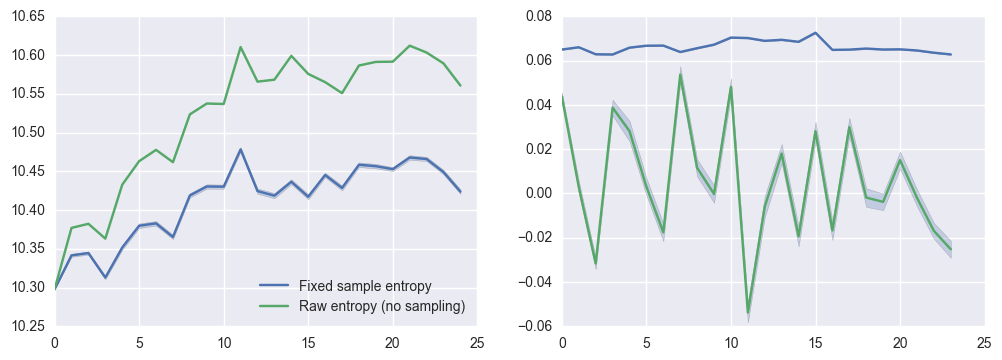

In [42]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
ax = axes[0]
ax.plot(ent_m,label='Fixed sample entropy')
ax.fill_between(range(len(ent_m)),ent_m-ent_c,ent_m+ent_c,alpha=.25)
ax.plot(df_global.ix['ents']['data'],label='Raw entropy (no sampling)')
ax.legend(loc='lower right')
ax = axes[1]
ax.plot(jsd_m)
ax.fill_between(range(len(jsd_m)),jsd_m-jsd_c,jsd_m+jsd_c,alpha=.25,label='jsd')
ax.plot(ent_dif_m)
ax.fill_between(range(len(ent_dif_m)),ent_dif_m-ent_dif_c,ent_dif_m+ent_dif_c,alpha=.25,label='jsd')

array([ 10.29774563,  10.37692327,  10.38223761,  10.36313049,
        10.43266958,  10.46304161,  10.47758588,  10.46172396,
        10.52341852,  10.53739798,  10.53681566,  10.61024565,
        10.56564401,  10.56818017,  10.59893046,  10.57560562,
        10.56501397,  10.55083498,  10.58648683,  10.59112576,
        10.59140983,  10.61207489,  10.60320908,  10.58919205,  10.56063718])

In [31]:
df_local

,data
measure,
ents,"[10.2977456344, 10.3769232742, 10.3822376092, ..."
ent_difs,"[0.0791776397923, 0.00531433502607, -0.0191071..."
jsds,"[0.0600639763423, 0.054780415012, 0.0494263193..."
entdif-null_m,"[0.0271303474913, 0.000430400350987, 0.0102463..."
entdif-null_c,"[0.00191451631235, 0.00189973937373, 0.0018998..."
jsd-null_m,"[0.0381642497512, 0.0328473367937, 0.031116496..."
jsd-null_c,"[0.000207289539999, 6.14052182436e-05, 0.00011..."


In [43]:
cat_pubs_by_year['Computer Science, Artificial Intelligence']

1991     1756.0
1992     2366.0
1993     2440.0
1994     2678.0
1995     4118.0
1996     4149.0
1997     5110.0
1998     5090.0
1999     5537.0
2000     5891.0
2001     5744.0
2002     8436.0
2003    10870.0
2004    12643.0
2005    16272.0
2006    16983.0
2007     7114.0
2008     7989.0
2009     9175.0
2010     9290.0
2011    10917.0
2012    11555.0
2013    11408.0
2014    12404.0
2015    12341.0
Name: Computer Science, Artificial Intelligence, dtype: float64